In [2]:
%reset -f
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_excel('DataFromPowerBI.xlsx')
df.head(3)

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_type,AVG_Glucose_Level,BMI,Smoking Status,Age_Interval,Weight Condition,Glucose Condition,Age-Group,is_Urban,Stroke_Status
0,Male,35.0,0,0,0,Private,Rural,85.37,33.0,never smoked,30-40,Obese,Normal,4,0,0
1,Male,34.0,0,0,1,Private,Urban,80.81,33.2,never smoked,30-40,Obese,Normal,4,1,0
2,Female,31.0,0,0,1,Private,Urban,98.99,31.2,never smoked,30-40,Obese,Normal,4,1,0


In [4]:
df = df.drop(['Age','Age_Interval','BMI','AVG_Glucose_Level','Residence_type','Gender'],axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hypertension       5109 non-null   int64 
 1   Heart_Disease      5109 non-null   int64 
 2   Ever_Married       5109 non-null   int64 
 3   Work_Type          5109 non-null   object
 4   Smoking Status     5109 non-null   object
 5   Weight Condition   5109 non-null   object
 6   Glucose Condition  5109 non-null   object
 7   Age-Group          5109 non-null   int64 
 8   is_Urban           5109 non-null   int64 
 9   Stroke_Status      5109 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 399.3+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hypertension,5109.0,0.097475,0.296633,0.0,0.0,0.0,0.0,1.0
Heart_Disease,5109.0,0.054022,0.226084,0.0,0.0,0.0,0.0,1.0
Ever_Married,5109.0,0.656293,0.474991,0.0,0.0,1.0,1.0,1.0
Age-Group,5109.0,4.883735,2.264384,1.0,3.0,5.0,7.0,9.0
is_Urban,5109.0,0.508123,0.499983,0.0,0.0,1.0,1.0,1.0
Stroke_Status,5109.0,0.048738,0.215340,0.0,0.0,0.0,0.0,1.0


In [7]:
df.describe(include = 'object').T

,count,unique,top,freq
Work_Type,5109,5,Private,2924
Smoking Status,5109,4,never smoked,1892
Weight Condition,5109,5,Obese,1920
Glucose Condition,5109,3,Normal,3131


In [8]:
df['Smoking Status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: Smoking Status, dtype: int64

In [9]:
df['Weight Condition'].value_counts()

Obese          1920
Overweight     1409
Normal         1242
Underweight     337
Unknown         201
Name: Weight Condition, dtype: int64

Assumption: Age group 1 has never smoked:

In [10]:
mask = (df['Smoking Status'] == 'Unknown') & (df['Age-Group']==1)
df.loc[mask,'Smoking Status'] = 'never smoked'
df['Smoking Status'].value_counts()

never smoked       2364
Unknown            1072
formerly smoked     884
smokes              789
Name: Smoking Status, dtype: int64

# Method 1: Remove rows containing missing values

In [11]:
mask = (df['Weight Condition'] =='Unknown') | (df['Smoking Status'] =='Unknown')
df_method1 = df.drop(df[mask].index)

In [12]:
cols=df_method1.select_dtypes(include=['object']).columns

In [13]:
Encoded_df = pd.get_dummies(df_method1[cols])
cols=df_method1.select_dtypes(include=['int']).columns
Encoded_df = pd.concat([Encoded_df, df_method1[cols]], axis=1)
Encoded_df.head()

,Work_Type_Govt_job,Work_Type_Never_worked,Work_Type_Private,Work_Type_Self-employed,Work_Type_children,Smoking Status_formerly smoked,Smoking Status_never smoked,Smoking Status_smokes,Weight Condition_Normal,Weight Condition_Obese,...,Weight Condition_Underweight,Glucose Condition_Diabetes,Glucose Condition_Normal,Glucose Condition_Pre-Diabetes,Hypertension,Heart_Disease,Ever_Married,Age-Group,is_Urban,Stroke_Status
0,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,4,0,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,4,1,0
2,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,4,1,0
3,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,4,0,0
4,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,4,1,0


To avoid dummy encoding trap, the redundant columns should be dropped:

In [14]:
Encoded_df = Encoded_df.drop(['Work_Type_Never_worked','Smoking Status_never smoked','Weight Condition_Normal','Glucose Condition_Normal'],axis=1)

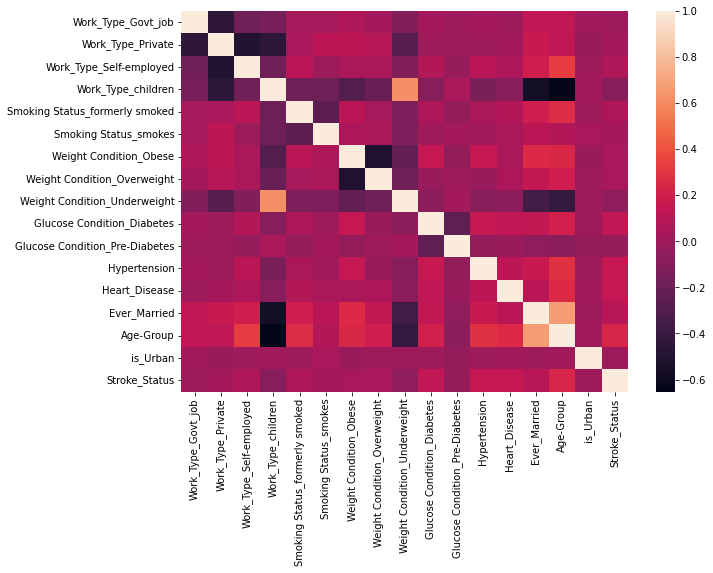

In [15]:
plt.figure(figsize=(10,7))
sns.heatmap(Encoded_df.corr(),annot=False,fmt='.2');

In [16]:
Encoded_df.corr()['Stroke_Status'].sort_values()[:-1]

Work_Type_children               -0.087152
Weight Condition_Underweight     -0.058084
Glucose Condition_Pre-Diabetes   -0.029367
Work_Type_Govt_job               -0.002967
is_Urban                          0.005031
Smoking Status_smokes             0.015131
Work_Type_Private                 0.017293
Weight Condition_Overweight       0.034177
Weight Condition_Obese            0.035909
Smoking Status_formerly smoked    0.054402
Work_Type_Self-employed           0.062469
Ever_Married                      0.102949
Glucose Condition_Diabetes        0.130013
Heart_Disease                     0.143976
Hypertension                      0.152148
Age-Group                         0.235945
Name: Stroke_Status, dtype: float64

**Defining  Metrics**

In [17]:
# Defining function for calculating Metrics

def calculate_metrics(model_name,y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    
    Sensitivity      = TP/(TP+FN)
    Specificity      = TN/(TN+FP)
    Precision        = TP/(TP+FP)
    Accuracy         = (TP+TN)/(TP+FP+FN+TN)
    F1               = (2*Sensitivity*Precision)/(Sensitivity+Precision)
             
    return pd.DataFrame({f'{model_name}':{
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'Precision'  : Precision,
        'Accuracy'   : Accuracy,
        'F1'         : F1
    }})

**Defining Train and Test Splits**

In [18]:
X = Encoded_df.iloc[:,0:-1]
y = Encoded_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.30 ,random_state=11)

**Scaling the data (only applicable to the age gruop)**

In [19]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
X       = sc.transform(X)


**Using SMOTE to upsampling the data**

In [20]:
# !pip install imblearn
from imblearn.over_sampling import SMOTE

In [21]:
smote=SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)
X_test,y_test   = smote.fit_resample(X_test,y_test)
X,y             = smote.fit_resample(X,y)

**Finding Best Hyper Parameters Before Building Models**

In [22]:
from sklearn.model_selection import GridSearchCV
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (svm.SVC(),[{'C':[0.25,0.5,0.75,1,1.5,2],'kernel':['linear', 'rbf'],'random_state':[0]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[200,500,1000],'criterion':['gini','entropy'],'random_state':[0]}]),
               (GaussianNB(),[{'var_smoothing': [1e-09]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[3,5,7,8,10],
                                         'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]), 
               (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]

In [23]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'f1',cv = 10)
    grid.fit(X_train, y_train)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('------------------------------------------------')
    print('')

LogisticRegression():
Best Accuracy : 80.16%
Best Parameters :  {'C': 1, 'random_state': 0}

------------------------------------------------

SVC():
Best Accuracy : 91.46%
Best Parameters :  {'C': 2, 'kernel': 'rbf', 'random_state': 0}

------------------------------------------------

DecisionTreeClassifier():
Best Accuracy : 95.07%
Best Parameters :  {'criterion': 'gini', 'random_state': 0}

------------------------------------------------

RandomForestClassifier():
Best Accuracy : 96.20%
Best Parameters :  {'criterion': 'entropy', 'n_estimators': 500, 'random_state': 0}

------------------------------------------------

GaussianNB():
Best Accuracy : 73.52%
Best Parameters :  {'var_smoothing': 1e-09}

------------------------------------------------

KNeighborsClassifier():
Best Accuracy : 93.22%
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 3}

------------------------------------------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              co

**1) Logistic Regression (Method 1)**

In [24]:
Logistic_model = LogisticRegression(C=1)
cross_val_score(Logistic_model, X, y, cv=10).mean()

0.7358328774118247

In [25]:
Logistic_model.fit(X_train,y_train)

LogisticRegression(C=0.5)

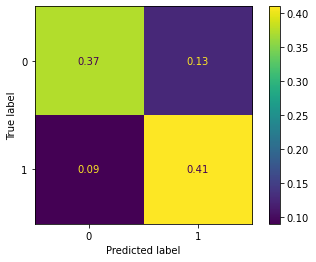

In [26]:
y_pred = Logistic_model.predict(X_test)
plot_confusion_matrix(Logistic_model,X_test,y_test, normalize = 'all');

In [27]:
df_metrics_method_1 = calculate_metrics("Logistic Regression",y_test, y_pred)
df_metrics_method_1

,Logistic Regression
Accuracy,0.783333
F1,0.790960
Precision,0.764064
Sensitivity,0.819820
Specificity,0.746847


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**2) Support Vector Machine (Method 1)**

In [28]:
svm_model = svm.SVC(C=2,kernel='rbf')
cross_val_score(svm_model, X, y, cv=10).mean()

0.7713303789619579

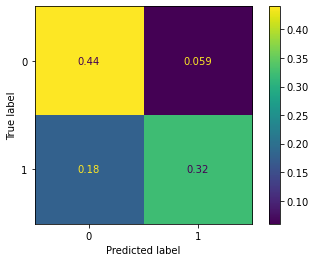

In [29]:
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
plot_confusion_matrix(svm_model,X_test,y_test, normalize='all');

In [30]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("SVM",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM
Accuracy,0.783333,0.762162
F1,0.790960,0.730061
Precision,0.764064,0.843972
Sensitivity,0.819820,0.643243
Specificity,0.746847,0.881081


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**3) Decision Tree (Method 1)**

In [31]:
DT_model = DecisionTreeClassifier(criterion= 'gini')
cross_val_score(DT_model, X, y, cv=10).mean()

0.8605472881788672

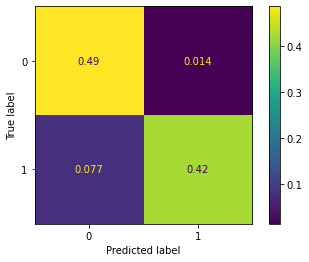

In [32]:
DT_model.fit(X_train,y_train)
y_pred = DT_model.predict(X_test)
plot_confusion_matrix(DT_model,X_test,y_test,normalize='all');

In [33]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("Decition Tree",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM,Decition Tree
Accuracy,0.783333,0.762162,0.908559
F1,0.790960,0.730061,0.902451
Precision,0.764064,0.843972,0.967044
Sensitivity,0.819820,0.643243,0.845946
Specificity,0.746847,0.881081,0.971171


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**4) Random Forests (Method 1)**

In [34]:
RF_model = RandomForestClassifier(criterion='entropy', n_estimators= 500)
cross_val_score(RF_model, X, y, cv=10).mean()

0.8583960681329103

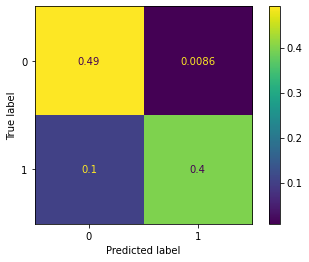

In [35]:
RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
plot_confusion_matrix(RF_model,X_test,y_test,normalize='all');

In [36]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("Random Forest",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM,Decition Tree,Random Forest
Accuracy,0.783333,0.762162,0.908559,0.890090
F1,0.790960,0.730061,0.902451,0.878848
Precision,0.764064,0.843972,0.967044,0.978982
Sensitivity,0.819820,0.643243,0.845946,0.797297
Specificity,0.746847,0.881081,0.971171,0.982883


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**5) Naive Bayes (Method 1)**

In [37]:
NB_model = GaussianNB()
cross_val_score(NB_model, X, y, cv=10).mean()

0.6313737826895721

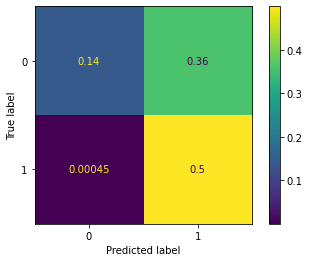

In [38]:
NB_model.fit(X_train, y_train)
y_pred = NB_model.predict(X_test)
plot_confusion_matrix(NB_model,X_test,y_test,normalize='all');

In [39]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("Naive Bays",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays
Accuracy,0.783333,0.762162,0.908559,0.890090,0.641441
F1,0.790960,0.730061,0.902451,0.878848,0.735899
Precision,0.764064,0.843972,0.967044,0.978982,0.582458
Sensitivity,0.819820,0.643243,0.845946,0.797297,0.999099
Specificity,0.746847,0.881081,0.971171,0.982883,0.283784


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**6) KNN (Method 1)**

In [40]:
KNN_model = KNeighborsClassifier(metric= 'manhattan', n_neighbors=3)
cross_val_score(KNN_model, X, y, cv=10).mean()

0.7976474450158662

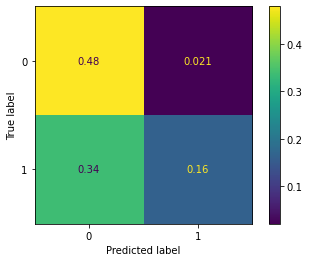

In [41]:
KNN_model.fit(X_train, y_train)
y_pred = KNN_model.predict(X_test)
plot_confusion_matrix(KNN_model,X_test,y_test,normalize='all');

In [42]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("KNN",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays,KNN
Accuracy,0.783333,0.762162,0.908559,0.890090,0.641441,0.641892
F1,0.790960,0.730061,0.902451,0.878848,0.735899,0.476629
Precision,0.764064,0.843972,0.967044,0.978982,0.582458,0.885086
Sensitivity,0.819820,0.643243,0.845946,0.797297,0.999099,0.326126
Specificity,0.746847,0.881081,0.971171,0.982883,0.283784,0.957658


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**7) XGBoost (Method 1)**

In [43]:
XGB_model = XGBClassifier(eval_metric='error', learning_rate=0.1)
cross_val_score(XGB_model, X, y, cv=10).mean()

0.8789088886457307

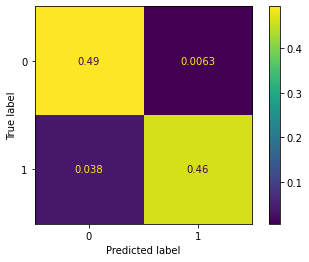

In [44]:
XGB_model.fit(X_train,y_train)
y_pred=XGB_model.predict(X_test)
plot_confusion_matrix(XGB_model,X_test,y_test,normalize='all');

In [45]:
df_metrics_method_1 = df_metrics_method_1.merge(calculate_metrics("XGBoost",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_1

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays,KNN,XGBoost
Accuracy,0.783333,0.762162,0.908559,0.890090,0.641441,0.641892,0.955856
F1,0.790960,0.730061,0.902451,0.878848,0.735899,0.476629,0.954419
Precision,0.764064,0.843972,0.967044,0.978982,0.582458,0.885086,0.986538
Sensitivity,0.819820,0.643243,0.845946,0.797297,0.999099,0.326126,0.924324
Specificity,0.746847,0.881081,0.971171,0.982883,0.283784,0.957658,0.987387


# Method 2: Dropping the Smoking-Status column

In [46]:
mask = (df['Weight Condition'] =='Unknown')
df_method2 = df.drop(df[mask].index).drop('Smoking Status',axis=1)

In [47]:
cols=df_method2.select_dtypes(include=['object']).columns
Encoded_df = pd.get_dummies(df_method2[cols])

In [48]:
cols=df_method2.select_dtypes(include=['int']).columns
Encoded_df = pd.concat([Encoded_df, df_method2[cols]], axis=1)
Encoded_df.head()

,Work_Type_Govt_job,Work_Type_Never_worked,Work_Type_Private,Work_Type_Self-employed,Work_Type_children,Weight Condition_Normal,Weight Condition_Obese,Weight Condition_Overweight,Weight Condition_Underweight,Glucose Condition_Diabetes,Glucose Condition_Normal,Glucose Condition_Pre-Diabetes,Hypertension,Heart_Disease,Ever_Married,Age-Group,is_Urban,Stroke_Status
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,4,0,0
1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,4,1,0
2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,4,1,0
3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,4,0,0
4,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,4,1,0


In [49]:
X = Encoded_df.iloc[:,0:-1]
y = Encoded_df.iloc[:,-1]
X_train,X_test,y_train,y_test  = train_test_split(X, y, test_size=0.30 ,random_state=11)

**Scaling the data (only applicable to the age gruop)**

In [50]:
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
X       = sc.transform(X)

**Using SMOTE to upsampling dataset**

In [51]:
smote=SMOTE()
X_train,y_train   = smote.fit_resample(X_train,y_train)
X_test,y_test     = smote.fit_resample(X_test,y_test)
X,y               = smote.fit_resample(X,y)

**Tuning Hyper Parameters before Building Models**

In [52]:
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (svm.SVC(),[{'C':[0.25,0.5,0.75,1,1.5,2],'kernel':['linear', 'rbf'],'random_state':[0]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[200,500,1000],'criterion':['gini','entropy'],'random_state':[0]}]),
               (GaussianNB(),[{'var_smoothing': [1e-09]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[3,5,7], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]), 
               (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]

In [53]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'f1',cv = 10)
    grid.fit(X_train, y_train)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('------------------------------------------------')
    print('')

LogisticRegression():
Best Accuracy : 78.25%
Best Parameters :  {'C': 0.75, 'random_state': 0}

------------------------------------------------

SVC():
Best Accuracy : 87.68%
Best Parameters :  {'C': 2, 'kernel': 'rbf', 'random_state': 0}

------------------------------------------------

DecisionTreeClassifier():
Best Accuracy : 94.79%
Best Parameters :  {'criterion': 'gini', 'random_state': 0}

------------------------------------------------

RandomForestClassifier():
Best Accuracy : 94.93%
Best Parameters :  {'criterion': 'gini', 'n_estimators': 500, 'random_state': 0}

------------------------------------------------

GaussianNB():
Best Accuracy : 70.10%
Best Parameters :  {'var_smoothing': 1e-09}

------------------------------------------------

KNeighborsClassifier():
Best Accuracy : 90.46%
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 3}

------------------------------------------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              co

**1) Logistic Regression (Method 2)**

In [57]:
Logistic_model = LogisticRegression(C=0.75)
cross_val_score(Logistic_model, X, y, cv=10).mean()

0.7222870641016926

In [58]:
Logistic_model.fit(X_train,y_train)

LogisticRegression(C=0.75)

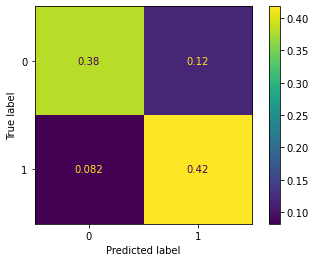

In [59]:
y_pred = Logistic_model.predict(X_test)
plot_confusion_matrix(Logistic_model,X_test,y_test, normalize = 'all');

In [60]:
df_metrics_method_2 = calculate_metrics("Logistic Regression",y_test, y_pred)
df_metrics_method_2

,Logistic Regression
Accuracy,0.799788
F1,0.806683
Precision,0.779829
Sensitivity,0.835452
Specificity,0.764124


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**2) Support Vector Machine (Method 2)**

In [61]:
svm_model = svm.SVC(kernel='rbf',C=2)
cross_val_score(svm_model, X, y, cv=10).mean()

0.6898393492397978

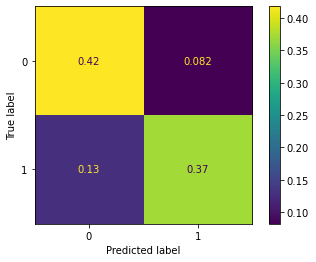

In [62]:
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
plot_confusion_matrix(svm_model,X_test,y_test, normalize='all');

In [63]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("SVM",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM
Accuracy,0.799788,0.789901
F1,0.806683,0.779711
Precision,0.779829,0.819455
Sensitivity,0.835452,0.743644
Specificity,0.764124,0.836158


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**3) Decision Tree (Method 2)**

In [64]:
DT_model = DecisionTreeClassifier(criterion='gini')
cross_val_score(DT_model, X, y, cv=10).mean()

0.8271999410871684

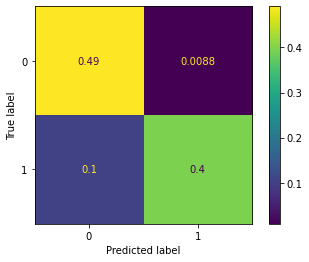

In [65]:
DT_model.fit(X_train,y_train)
y_pred = DT_model.predict(X_test)
plot_confusion_matrix(DT_model,X_test,y_test,normalize='all');

In [66]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("Decition Tree",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM,Decition Tree
Accuracy,0.799788,0.789901,0.886653
F1,0.806683,0.779711,0.874658
Precision,0.779829,0.819455,0.978166
Sensitivity,0.835452,0.743644,0.790960
Specificity,0.764124,0.836158,0.982345


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**4) Random Forests (Method 2)**

In [67]:
RF_model = RandomForestClassifier(criterion='gini', n_estimators=500)
cross_val_score(RF_model, X, y, cv=10).mean()

0.7970808691908549

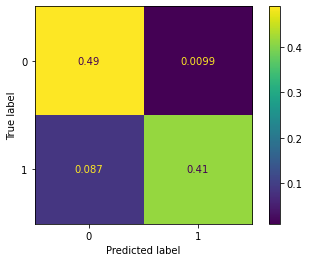

In [68]:
RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
plot_confusion_matrix(RF_model,X_test,y_test,normalize='all');

In [69]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("Random Forest",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM,Decition Tree,Random Forest
Accuracy,0.799788,0.789901,0.886653,0.903602
F1,0.806683,0.779711,0.874658,0.895602
Precision,0.779829,0.819455,0.978166,0.976647
Sensitivity,0.835452,0.743644,0.790960,0.826977
Specificity,0.764124,0.836158,0.982345,0.980226


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**5) Naive Bayes (Method 2)**

In [70]:
NB_model = GaussianNB()
cross_val_score(NB_model, X, y, cv=10).mean()

0.6140930822740354

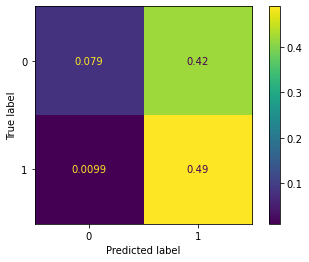

In [71]:
NB_model.fit(X_train, y_train)
y_pred = NB_model.predict(X_test)
plot_confusion_matrix(NB_model,X_test,y_test,normalize='all');

In [72]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("Naive Bays",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays
Accuracy,0.799788,0.789901,0.886653,0.903602,0.569562
F1,0.806683,0.779711,0.874658,0.895602,0.694869
Precision,0.779829,0.819455,0.978166,0.976647,0.538193
Sensitivity,0.835452,0.743644,0.790960,0.826977,0.980226
Specificity,0.764124,0.836158,0.982345,0.980226,0.158898


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**6) KNN (Method 2)**

In [73]:
KNN_model = KNeighborsClassifier(metric='manhattan',n_neighbors=3)
cross_val_score(KNN_model, X, y, cv=10).mean()

0.7012192690277116

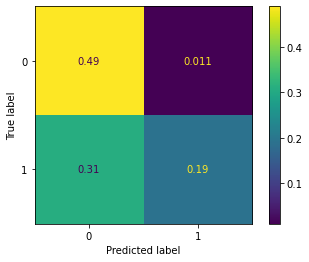

In [74]:
KNN_model.fit(X_train, y_train)
y_pred = KNN_model.predict(X_test)
plot_confusion_matrix(KNN_model,X_test,y_test,normalize='all');

In [75]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("KNN",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays,KNN
Accuracy,0.799788,0.789901,0.886653,0.903602,0.569562,0.680438
F1,0.806683,0.779711,0.874658,0.895602,0.694869,0.545455
Precision,0.779829,0.819455,0.978166,0.976647,0.538193,0.944348
Sensitivity,0.835452,0.743644,0.790960,0.826977,0.980226,0.383475
Specificity,0.764124,0.836158,0.982345,0.980226,0.158898,0.977401


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**7) XGBoost (Method 2)**

In [76]:
XGB_model = XGBClassifier(eval_metric='error', learning_rate= 0.1)
cross_val_score(XGB_model, X, y, cv=10).mean()

0.8185761221761492

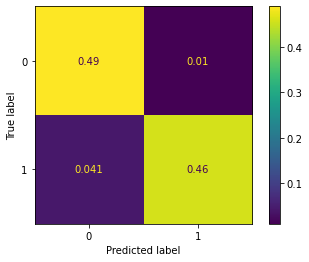

In [77]:
XGB_model.fit(X_train,y_train)
y_pred=XGB_model.predict(X_test)
plot_confusion_matrix(XGB_model,X_test,y_test,normalize='all');

In [78]:
df_metrics_method_2 = df_metrics_method_2.merge(calculate_metrics("XGBoost",y_test, y_pred), left_index=True, right_index=True)
df_metrics_method_2

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays,KNN,XGBoost
Accuracy,0.799788,0.789901,0.886653,0.903602,0.569562,0.680438,0.948446
F1,0.806683,0.779711,0.874658,0.895602,0.694869,0.545455,0.946793
Precision,0.779829,0.819455,0.978166,0.976647,0.538193,0.944348,0.978163
Sensitivity,0.835452,0.743644,0.790960,0.826977,0.980226,0.383475,0.917373
Specificity,0.764124,0.836158,0.982345,0.980226,0.158898,0.977401,0.979520


**Difference between Method 1 and 2:**

In [79]:
difference = df_metrics_method_2 - df_metrics_method_1
difference

,Logistic Regression,SVM,Decition Tree,Random Forest,Naive Bays,KNN,XGBoost
Accuracy,0.016455,0.027739,-0.021906,0.013512,-0.071879,0.038546,-0.007410
F1,0.015722,0.049650,-0.027792,0.016754,-0.041031,0.068825,-0.007626
Precision,0.015765,-0.024516,0.011122,-0.002335,-0.044265,0.059262,-0.008376
Sensitivity,0.015632,0.100401,-0.054985,0.029680,-0.018873,0.057348,-0.006951
Specificity,0.017277,-0.044923,0.011173,-0.002657,-0.124885,0.019743,-0.007868


# Bonus: Effect of Glucose

In [80]:
df_b = pd.read_excel('DataFromPowerBI.xlsx')

In [81]:
df_b = df_b.drop(['Age','Age_Interval','BMI','Residence_type','Gender','Glucose Condition'],axis=1)

In [82]:
df_b['Glucose'] = pd.cut(df_b['AVG_Glucose_Level'],25)
df_b['Glucose'] = df_b['Glucose'].astype('object')

In [83]:
# mask = (df_b['Weight Condition'] =='Unknown')
# df_b = df_b.drop(df_b[mask].index).drop('Smoking Status',axis=1)

In [84]:
cols=df_b.select_dtypes(include=['object']).columns
Encoded_df_b = pd.get_dummies(df_b[cols])

In [85]:
cols=df_b.select_dtypes(include=['int']).columns
Encoded_df_b = pd.concat([Encoded_df_b, df_b[cols]], axis=1)
Encoded_df_b = Encoded_df_b.drop(['Work_Type_Never_worked','Weight Condition_Normal'],axis=1)

In [86]:
mask = (Encoded_df_b.corr().index.str.startswith('Glucose_')) & (abs(Encoded_df_b.corr()['Stroke_Status'])>0.01)
Encoded_df_b.corr()['Stroke_Status'].loc[mask].sort_values()


Glucose_(81.114, 89.779]     -0.038214
Glucose_(89.779, 98.444]     -0.023912
Glucose_(107.109, 115.774]   -0.019125
Glucose_(63.785, 72.45]      -0.018418
Glucose_(115.774, 124.438]   -0.014622
Glucose_(150.433, 159.098]   -0.014203
Glucose_(141.768, 150.433]   -0.012796
Glucose_(72.45, 81.114]      -0.012581
Glucose_(98.444, 107.109]    -0.012146
Glucose_(54.903, 63.785]     -0.011978
Glucose_(124.438, 133.103]   -0.011830
Glucose_(254.41, 263.075]     0.014026
Glucose_(176.427, 185.092]    0.023551
Glucose_(167.762, 176.427]    0.025284
Glucose_(159.098, 167.762]    0.028900
Glucose_(219.751, 228.416]    0.037350
Glucose_(202.422, 211.086]    0.039179
Glucose_(263.075, 271.74]     0.040766
Glucose_(228.416, 237.081]    0.042073
Glucose_(245.746, 254.41]     0.042290
Glucose_(237.081, 245.746]    0.046138
Glucose_(185.092, 193.757]    0.046858
Glucose_(211.086, 219.751]    0.051992
Glucose_(193.757, 202.422]    0.067757
Name: Stroke_Status, dtype: float64

# Association Rules

**Apriori Algorithm**

In [87]:
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

In [88]:
mask = (df_method1['Weight Condition'] =='Unknown')
cols = ['Hypertension', 'Heart_Disease', 'Smoking Status', 'Weight Condition', 'Glucose Condition','Stroke_Status']
df_ap = df_method1.drop(df_method1[mask].index).loc[:,cols]

In [89]:
Encoded_df_ap = pd.get_dummies(df_ap)

In [90]:
ap = apriori(Encoded_df_ap, min_support = 0.04, use_colnames = True, verbose = 1)

Processing 4 combinations | Sampling itemset size 4


In [91]:
df_ap_rules = association_rules(ap, metric = "confidence", min_threshold = 0.60)

In [92]:
pd. set_option('display.max_columns', None) # or 1000.
pd. set_option('display.max_rows', None) # or 1000.
pd. set_option('display.max_colwidth', 199) # or 199.

In [93]:
df_ap_rules.sort_values(by='confidence', ascending=False).query(' lift > 1.05')[['antecedents','consequents','support','confidence','lift']]

,antecedents,consequents,support,confidence,lift
13,"(Weight Condition_Underweight, Glucose Condition_Normal)",(Smoking Status_never smoked),0.048661,0.964286,1.620634
2,(Weight Condition_Underweight),(Smoking Status_never smoked),0.071061,0.948454,1.594026
14,"(Weight Condition_Underweight, Smoking Status_never smoked)",(Glucose Condition_Normal),0.048661,0.684783,1.126035
16,"(Weight Condition_Overweight, Smoking Status_smokes)",(Glucose Condition_Normal),0.042225,0.674897,1.109780
8,(Weight Condition_Underweight),(Glucose Condition_Normal),0.050463,0.673540,1.107548
1,(Weight Condition_Normal),(Smoking Status_never smoked),0.161946,0.670576,1.127008
10,"(Glucose Condition_Normal, Weight Condition_Normal)",(Smoking Status_never smoked),0.103759,0.660656,1.110336
6,(Weight Condition_Normal),(Glucose Condition_Normal),0.157055,0.650320,1.069366
15,(Weight Condition_Underweight),"(Glucose Condition_Normal, Smoking Status_never smoked)",0.048661,0.649485,1.762822
11,"(Smoking Status_never smoked, Weight Condition_Normal)",(Glucose Condition_Normal),0.103759,0.640700,1.053547


**Apriori as Classifier**

In [156]:
mask = (df_method1['Weight Condition'] =='Unknown')
cols = ['Hypertension', 'Heart_Disease', 'Smoking Status', 'Weight Condition', 'Glucose Condition','Stroke_Status']
df_ap = df_method1.drop(df_method1[mask].index).loc[:,cols]
Encoded_df_ap = pd.get_dummies(df_ap)
ap = apriori(Encoded_df_ap, min_support = 0.001, use_colnames = True, verbose = 1)
df_ap_rules = association_rules(ap, metric = "confidence", min_threshold = 0.35)

Processing 54 combinations | Sampling itemset size 6


In [157]:
rules_df = df_ap_rules.sort_values(by='confidence', ascending=False).query(' lift > 1.01')[['antecedents','consequents','support','confidence','lift']]

In [158]:
rules_df[rules_df["consequents"].apply(lambda x: 'Stroke' in str(x))]

,antecedents,consequents,support,confidence,lift
268,"(Heart_Disease, Glucose Condition_Diabetes, Smoking Status_smokes)",(Stroke_Status),0.002060,0.421053,9.085380
395,"(Glucose Condition_Diabetes, Heart_Disease, Weight Condition_Obese, Smoking Status_smokes)",(Stroke_Status),0.001287,0.416667,8.990741
388,"(Glucose Condition_Diabetes, Heart_Disease, Smoking Status_never smoked, Weight Condition_Overweight)",(Stroke_Status),0.001287,0.384615,8.299145
346,"(Glucose Condition_Diabetes, Heart_Disease, Hypertension, Weight Condition_Obese)",(Stroke_Status),0.001287,0.357143,7.706349


# Neural Network

In [96]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [97]:
# build Sequential ANN model
Neurons_Trial=8
Optimizer_Trial='adam'

# Creating the classifier ANN model
ANN_model = Sequential()
ANN_model.add(Dense(units=Neurons_Trial, input_dim=17, kernel_initializer='uniform', activation='relu'))
ANN_model.add(Dense(units=Neurons_Trial, kernel_initializer='uniform', activation='relu'))
ANN_model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ANN_model.compile(optimizer=Optimizer_Trial, loss='binary_crossentropy', metrics=['accuracy'])
    

# model fit 
weights = {0:1, 1:20}
history = ANN_model.fit(X_train,
                    y_train,
                    class_weight=weights,
                    epochs=30, 
                    batch_size=25,
                    validation_split=0.4,
                    shuffle=True,
                    verbose=1)

Epoch 1/30
158/158 [==============================] - 3s 5ms/step - loss: 2.4476 - accuracy: 0.1703 - val_loss: 0.2372 - val_accuracy: 1.0000
Epoch 2/30
158/158 [==============================] - 1s 3ms/step - loss: 1.6314 - accuracy: 0.3922 - val_loss: 0.1463 - val_accuracy: 0.9947
Epoch 3/30
158/158 [==============================] - 1s 3ms/step - loss: 1.4996 - accuracy: 0.4623 - val_loss: 0.1574 - val_accuracy: 0.9897
Epoch 4/30
158/158 [==============================] - 1s 4ms/step - loss: 1.4320 - accuracy: 0.5080 - val_loss: 0.1345 - val_accuracy: 0.9859
Epoch 5/30
158/158 [==============================] - 1s 4ms/step - loss: 1.4002 - accuracy: 0.5341 - val_loss: 0.1538 - val_accuracy: 0.9802
Epoch 6/30
158/158 [==============================] - 1s 6ms/step - loss: 1.3821 - accuracy: 0.5542 - val_loss: 0.1487 - val_accuracy: 0.9798
Epoch 7/30
158/158 [==============================] - 1s 5ms/step - loss: 1.3713 - accuracy: 0.5598 - val_loss: 0.1316 - val_accuracy: 0.9821
Epoch 

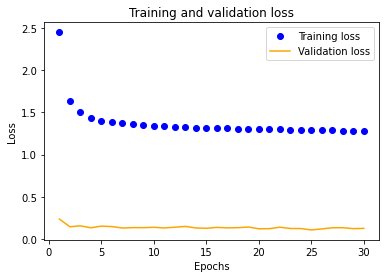

In [98]:
# Learning Curve
history_dict = history.history

# loss
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 

# No. of epochs
epochs = range(1, len(loss_values) + 1) 


plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
y_pred = ANN_model.predict(X_test)
for i,item in enumerate(y_pred):
    if item < 0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
        
calculate_metrics("ANN",y_test, y_pred)

,ANN
Accuracy,0.765184
F1,0.805612
Precision,0.687282
Sensitivity,0.973164
Specificity,0.557203


# Confidence Interval

In [100]:
import scipy.stats as stats
from scipy.optimize import fsolve

In [101]:
# Z for 95% confidence:
z_critical = stats.norm.ppf(q = 0.975)
round(z_critical,2)

1.96

In [159]:
N = len(X)      # number of Samples
f = 0.924324    # XGboost Recall (Sensitivity)
x0 = 0.95       # initial guess

def g1(P):
    return ((f-P)/((P*(1-P)/N) )**0.5)-z_critical
def g2(P):
    return ((f-P)/((P*(1-P)/N) )**0.5)+z_critical

lower_limit = round(float(fsolve(g1,x0)),4)*100
upper_limit = round(float(fsolve(g2,x0)),4)*100

print("Model Accuracy (95% Confidence Interval):",[lower_limit,upper_limit])

Model Accuracy (95% Confidence Interval): [91.88, 92.95]
